In [181]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

<h3>Business Analytics: We have provided a sample of 460 games (230 from the 2016-17 season and 230 from the 2017-18 season) for which your task is to predict total international viewers. To assist with your model, we have provided viewership numbers from 1,000 games by country in each of the two seasons, plus stats on team and player performance and status. Using these inputs, we would like you to predict the total number of international viewers for each of the 460 games in the test set.</h3>

<em>You will be graded on Mean Absolute Percentage Error (MAPE) on Total Viewers. We selected this metric due to natural scaling in the international viewership data. Further details on each source file and on the MAPE evaluation metric are provided in the prompt PDF made available here. Please return to us a copy of testset[Team_Name].csv with the “Total Viewers” column filled in with your response variable. Please note that each question is permitted a maximum of two file attachments. Please save your answer in a .csv file and save your code, spreadsheets and all other work in a zip file.</em>

<a href="https://nba.app.box.com/s/1qdbusoz1fmp1uxd4634zxxoudyv3ogc">LINK TO PROMPT .PDF</a>

In [77]:
# File Names
gameCSV = "game_data.csv"
playerCSV = "player_data.csv"
testCSV = "test_set.csv"
trainingCSV = "training_set.csv"

In [78]:
# Importing CSV Files
gameData = pd.read_csv("game_data.csv")
dfGameData = pd.DataFrame(gameData)

playerData = pd.read_csv("player_data.csv")
dfPlayerData = pd.DataFrame(playerData)

trainingSet = pd.DataFrame(pd.read_csv("training_set.csv"))

In [83]:
# Convert DateTime
dfGameData["Game_Date"] = pd.to_datetime(dfGameData["Game_Date"], infer_datetime_format=True)
dfPlayerData["Game_Date"] = pd.to_datetime(dfPlayerData["Game_Date"], infer_datetime_format=True)
trainingSet["Game_Date"] = pd.to_datetime(trainingSet["Game_Date"], infer_datetime_format=True)

# Remove Spaces from column names
trainingSet.rename(columns={"Rounded Viewers":"Viewers"}, inplace=True)

About 18-19% of the games are missing data. 
Lets save a dataframe that drops those.

In [84]:
dfGameDataNoNA = dfGameData.dropna(how='any')
print("Games in data with NAs: %d" % len(dfGameData))
print("Games in clean data: %d" % len(dfGameDataNoNA))

Games in data with NAs: 4920
Games in clean data: 4000


Looking at the different standard deviations, the variation in L2M scoring, 4Q Scoring will have a good measure.
Also, let's make the assumption that better teams are going to have more viewers

In [85]:
dfGameData.std()

Game_ID               50006.342937
Wins_Entering_Gm         13.678415
Losses_Entering_Gm       13.648129
Team_Minutes              7.098147
Final_Score              12.196321
Lead_Changes              2.840888
Ties                      2.427680
Largest_Lead              9.094207
Full_Timeouts             1.168729
Short_Timeouts            0.909046
Qtr_4_Score              10.376985
L2M_Score                11.714484
dtype: float64

### Multi-Colinearity Check
Highest colinearity looks like its going to be on the overall scoring, which makes sense, more scoring in 4Q means total score is likely to be higher. Same with full timeouts are probably down in blowouts.
The general lack of correation may make it a little harder to get a specific model.
<em>NOTE: No normalization was done so scale differences minimize some interesting ideas</em>

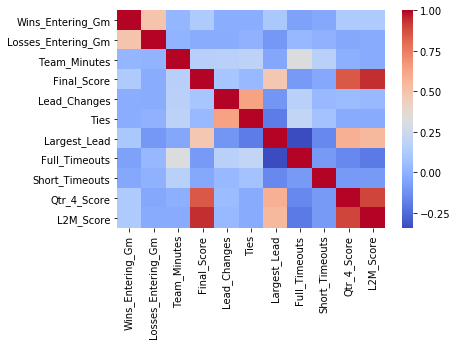

In [86]:
sb.heatmap(dfGameData.drop(columns=["Game_ID"]).corr(method='pearson'), cmap='coolwarm')

Lets keep it simple and make two linear regression models. One with all the variables, then one with selected "must watch" variables: Wins, Lead Changes, 4Q Scoring.

But first lets look if there are any easily discernable trends overall

/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

TypeError: __init__() takes at least 3 arguments (2 given)

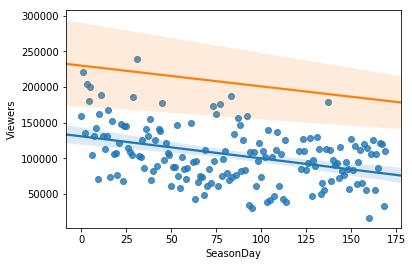

In [185]:
# Group By Season
seasons = pd.DataFrame(trainingSet.groupby(by=["Season","Game_Date"], as_index=False).sum())
viewers1617 = seasons[seasons["Season"] == "2016-17"]
viewers1718 = seasons[seasons["Season"] == "2017-18"]

# Create 'Day of Season' Variable
viewers1617["SeasonDay"] = viewers1617["Game_Date"] - min(viewers1617["Game_Date"])
viewers1718["SeasonDay"] = viewers1718["Game_Date"] - min(viewers1617["Game_Date"])
# Convert Time Deltas to Integer Values
viewers1617["SeasonDay"] = (viewers1617["SeasonDay"] / np.timedelta64(1, 'D')).astype(int)
viewers1718["SeasonDay"] = (viewers1718["SeasonDay"] / np.timedelta64(1, 'D')).astype(int)

# Plot
sb.regplot(x="SeasonDay", y="Viewers", data=viewers1617)
sb.regplot(x="SeasonDay", y="Viewers", data=viewers1718)

plt.annotate(s="Clear decline in viewership as season goes on", xycoord)

Timestamp('2017-04-12 00:00:00')